# Coursework title

other things

**Instructions to run this notebook:**

In [3]:
import pandas as pd
import numpy as np

## 4.2. Cleaning the data

In [4]:
# Load datasets
france_df = pd.read_excel("../data/raw/france_data.xlsx", sheet_name="International Financial Statis", header=2)  # Adjust filename and sheet name
us_df = pd.read_excel("../data/raw/us_data.xlsx", sheet_name="International Financial Statis", header=2)  # Adjust filename and sheet name

# Rename the first unnamed column to 'Date'
france_df.rename(columns={france_df.columns[0]: "Date"}, inplace=True)
us_df.rename(columns={us_df.columns[0]: "Date"}, inplace=True)

# Convert Date column to datetime format
france_df["Date"] = pd.to_datetime(france_df["Date"], format="%b %Y")
us_df["Date"] = pd.to_datetime(us_df["Date"], format="%b %Y")

# Rename columns for clarity
france_df.rename(columns={
    "Economic Activity, Industrial Production, Index": "Industrial_Production_Index_France",
    "Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate": "Exchange_Rate_France",
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "International_Reserves_France",
    "Prices, Consumer Price Index, All items, Index": "CPI_Index_France"
}, inplace=True)

us_df.rename(columns={
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "International_Reserves_US",
    "Prices, Consumer Price Index, All items, Index": "CPI_Index_US"
}, inplace=True)

# Merge datasets on Date
df = pd.merge(france_df, us_df, on="Date", how="inner")

# Print cleaned column names for debugging
print("Final Columns:", df.columns.tolist())

df


Final Columns: ['Date', 'Industrial_Production_Index_France', 'Exchange_Rate_France', 'International_Reserves_France', 'CPI_Index_France', 'International_Reserves_US', 'CPI_Index_US']


,Date,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,International_Reserves_US,CPI_Index_US
0,1959-12-01,35.365725,4.93706,1735.740000,10.208981,21504.500000,13.482806
1,1960-01-01,33.997257,4.93706,1753.740000,10.344146,21478.100000,13.436946
2,1960-02-01,34.793828,4.93706,1796.740000,10.367998,21395.700000,13.482806
3,1960-03-01,34.916378,4.93706,1869.760000,10.367998,21344.700000,13.482806
4,1960-04-01,35.712949,4.93706,1947.790000,10.383900,21278.000000,13.528666
...,...,...,...,...,...,...,...
368,1990-08-01,65.188579,5.27310,58918.106180,71.414243,78908.838357,60.351608
369,1990-09-01,90.517876,5.25750,62161.006201,71.921026,80024.166133,60.856066
370,1990-10-01,99.746380,5.10500,64564.495082,72.237766,82852.196532,61.222946
371,1990-11-01,94.543075,5.00050,66533.609260,72.121628,83059.402774,61.360525


### 4.2.1 Constructing variables for France

#### 1) Monthly Growth in Nominal Exchange Rate 
We will use the formula **ΔE_t / E_t-1** to define monthly growth in nominal exchange rate.

It will be calculated using '.pct_chnge()' which calculates the percentage difference between the values for each row and, by default, the previous row.

In [5]:
df["Nominal_Exchange_Growth"] = df["Exchange_Rate_France"].pct_change()

#### 2) Monthly Growth in Real Exchange Rate
Real Exchange Rate Formula: RER_t = (E_t * P*_t) / P_t

Where:
- E_t = Nominal Exchange Rate (France’s currency per USD)
- P*_t = US Consumer Price Index (US CPI)
- P_t = France Consumer Price Index (France CPI)

In [6]:
df["Real_Exchange_Rate"] = (df["Exchange_Rate_France"] * df["CPI_Index_US"]) / df["CPI_Index_France"]

# Real Exchange Rate Growth: (RER_t - RER_t-1) / RER_t-1
df["Real_Exchange_Growth"] = df["Real_Exchange_Rate"].pct_change()

#### 3) Index of Real Exchange Rate 
Base: Dec 1990 = 1

In [7]:
df["Real_Exchange_Index"] = df["Real_Exchange_Rate"] / df.loc[df["Date"] == "1990-12-01", "Real_Exchange_Rate"].values[0]

#### 4) Monthly Inflation Rate for France 
Monthly inflation rate formula: ΔCPI_t / CPI_t-1

In [8]:
df["France_Inflation"] = df["CPI_Index_US"].pct_change()

#### 5) Monthly Growth in Industrial Production

In [9]:
df["Industrial_Production_Growth"] = df["Industrial_Production_Index_France"].pct_change()

#### 6) Industrial Production Growth vs 12 Months Ago

In [10]:
df["Industrial_Production_YoY"] = df["Industrial_Production_Index_France"].pct_change(periods=12)

#### 7 International Reserves Index for France 
Base: Jan 1960 = 100

In [11]:
df["France_Reserves_Index"] = (df["International_Reserves_France"] / df.loc[df["Date"] == "1960-01-01", "International_Reserves_France"].values[0]) * 100

### 4.2.2. Constucting variables for the US

#### 1) Monthly Inflation Rate for the US

In [12]:
df["US_Inflation"] = df["CPI_Index_US"].pct_change()

#### 2) International Reserves Index for the US 
Base: Jan 1960 = 100

In [13]:
df["US_Reserves_Index"] = (df["International_Reserves_US"] / df.loc[df["Date"] == "1960-01-01", "International_Reserves_US"].values[0]) * 100

### 4.2.3. Identifying Outliers 
We will use a simple Z-score method to identify outliers with 95% confidence level.

In [14]:
def detect_outliers(series):
    z_scores = (series - series.mean()) / series.std()
    return series[(z_scores.abs() > 2)]  # Set threshold at 2 standard deviations

# List of variables to check for outliers
outlier_vars = [
    "Nominal_Exchange_Growth",
    "Real_Exchange_Growth",
    "France_Inflation",
    "Industrial_Production_Growth",
    "Industrial_Production_YoY",
    "France_Reserves_Index",
    "US_Inflation",
    "US_Reserves_Index"
]

# Mark outliers as missing (NaN)
for var in outlier_vars:
    df.loc[detect_outliers(df[var]).index, var] = np.nan

# Interpolation for missing values
df.interpolate(method="linear", inplace=True)

### 4.2.4. Save the dataframe

In [15]:
# Save cleaned and processed data
df.to_csv("../data/processed/processed_data.csv", index=False)

print("Data processing complete. Cleaned data saved as 'processed_data.csv'")

df

Data processing complete. Cleaned data saved as 'processed_data.csv'


,Date,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,International_Reserves_US,CPI_Index_US,Nominal_Exchange_Growth,Real_Exchange_Rate,Real_Exchange_Growth,Real_Exchange_Index,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index
0,1959-12-01,35.365725,4.93706,1735.740000,10.208981,21504.500000,13.482806,NaN,6.520281,NaN,1.511560,NaN,NaN,NaN,98.973622,NaN,100.122916
1,1960-01-01,33.997257,4.93706,1753.740000,10.344146,21478.100000,13.436946,0.000000,6.413193,-0.016424,1.486734,NaN,-0.038695,NaN,100.000000,NaN,100.000000
2,1960-02-01,34.793828,4.93706,1796.740000,10.367998,21395.700000,13.482806,0.000000,6.420277,0.001105,1.488376,0.003413,0.023430,NaN,102.451903,0.003413,99.616353
3,1960-03-01,34.916378,4.93706,1869.760000,10.367998,21344.700000,13.482806,0.000000,6.420277,0.000000,1.488376,0.000000,0.003522,NaN,106.615576,0.000000,99.378902
4,1960-04-01,35.712949,4.93706,1947.790000,10.383900,21278.000000,13.528666,0.000000,6.432249,0.001865,1.491152,0.003401,0.022814,NaN,111.064924,0.003401,99.068353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1990-08-01,65.188579,5.27310,58918.106180,71.414243,78908.838357,60.351608,-0.041342,4.456255,-0.038813,1.033068,0.009202,-0.258929,0.040973,3359.569046,0.009202,255.797994
369,1990-09-01,90.517876,5.25750,62161.006201,71.921026,80024.166133,60.856066,-0.002958,4.448640,-0.001709,1.031303,0.008359,0.388554,0.048188,3544.482432,0.008359,255.797994
370,1990-10-01,99.746380,5.10500,64564.495082,72.237766,82852.196532,61.222946,-0.029006,4.326589,-0.027436,1.003009,0.006029,0.101952,0.053401,3681.531760,0.006029,255.797994
371,1990-11-01,94.543075,5.00050,66533.609260,72.121628,83059.402774,61.360525,-0.020470,4.254387,-0.016688,0.986270,0.002247,-0.052165,-0.000580,3793.812610,0.002247,255.797994


In [16]:
# Extract rows where any column contains NaN (outliers were replaced with NaN)
outliers_found = df[df.isna().any(axis=1)]
outliers_found

,Date,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,International_Reserves_US,CPI_Index_US,Nominal_Exchange_Growth,Real_Exchange_Rate,Real_Exchange_Growth,Real_Exchange_Index,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index
0,1959-12-01,35.365725,4.93706,1735.74,10.208981,21504.5,13.482806,NaN,6.520281,NaN,1.511560,NaN,NaN,NaN,98.973622,NaN,100.122916
1,1960-01-01,33.997257,4.93706,1753.74,10.344146,21478.1,13.436946,0.0,6.413193,-0.016424,1.486734,NaN,-0.038695,NaN,100.000000,NaN,100.000000
2,1960-02-01,34.793828,4.93706,1796.74,10.367998,21395.7,13.482806,0.0,6.420277,0.001105,1.488376,0.003413,0.023430,NaN,102.451903,0.003413,99.616353
3,1960-03-01,34.916378,4.93706,1869.76,10.367998,21344.7,13.482806,0.0,6.420277,0.000000,1.488376,0.000000,0.003522,NaN,106.615576,0.000000,99.378902
4,1960-04-01,35.712949,4.93706,1947.79,10.383900,21278.0,13.528666,0.0,6.432249,0.001865,1.491152,0.003401,0.022814,NaN,111.064924,0.003401,99.068353
5,1960-05-01,35.743586,4.93706,2096.79,10.360048,21234.3,13.528666,0.0,6.447059,0.002302,1.494585,0.000000,0.000858,NaN,119.561052,0.000000,98.864890
6,1960-06-01,35.743586,4.93706,2057.79,10.352096,21169.8,13.574526,0.0,6.473882,0.004161,1.500803,0.003390,0.000000,NaN,117.337234,0.003390,98.564584
7,1960-07-01,33.016861,4.93706,2058.79,10.391851,20999.4,13.574526,0.0,6.449115,-0.003826,1.495062,0.000000,-0.076286,NaN,117.394255,0.000000,97.771218
8,1960-08-01,24.152452,4.93706,2168.79,10.487262,20803.4,13.574526,0.0,6.390443,-0.009098,1.481460,0.000000,-0.268481,NaN,123.666564,0.000000,96.858661
9,1960-09-01,34.569154,4.93706,2180.79,10.503163,20430.0,13.574526,0.0,6.380768,-0.001514,1.479217,0.000000,-0.104846,NaN,124.350816,0.000000,95.120146


i think i need to look into the industrial production new varibles as it is an index and idk if chat got that.

## 5.2. Analysis

### 5.2.1 Exchange Rate and International Reserve Graphs

Time series graphs:

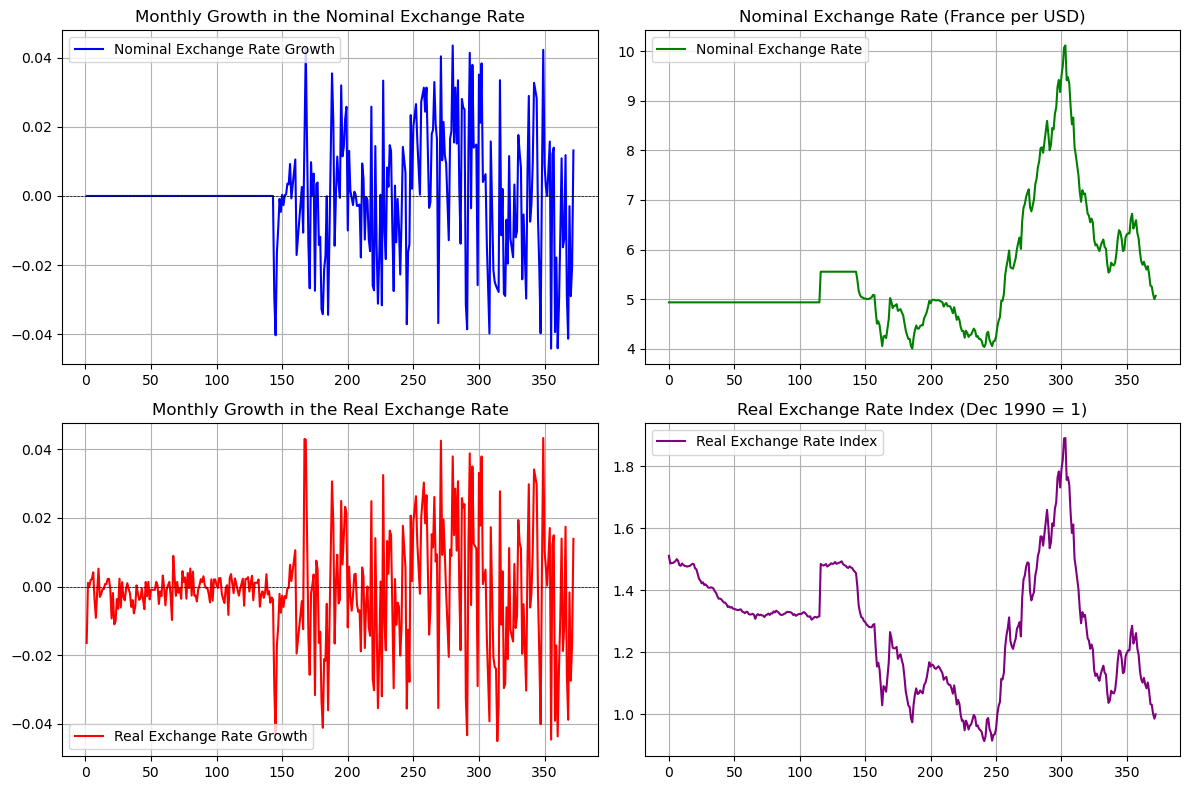

In [18]:
import matplotlib.pyplot as plt

# Plot all four graphs together
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Monthly Growth in the Nominal Exchange Rate
axes[0, 0].plot(df.index, df["Nominal_Exchange_Growth"], label="Nominal Exchange Rate Growth", color="blue")
axes[0, 0].set_title("Monthly Growth in the Nominal Exchange Rate")
axes[0, 0].axhline(y=0, color="black", linestyle="--", linewidth=0.5)

# 2. Level of the Nominal Exchange Rate
axes[0, 1].plot(df.index, df["Exchange_Rate_France"], label="Nominal Exchange Rate", color="green")
axes[0, 1].set_title("Nominal Exchange Rate (France per USD)")

# 3. Monthly Growth in the Real Exchange Rate
axes[1, 0].plot(df.index, df["Real_Exchange_Growth"], label="Real Exchange Rate Growth", color="red")
axes[1, 0].set_title("Monthly Growth in the Real Exchange Rate")
axes[1, 0].axhline(y=0, color="black", linestyle="--", linewidth=0.5)

# 4. Real Exchange Rate Index (Dec 1990 = 1)
axes[1, 1].plot(df.index, df["Real_Exchange_Index"], label="Real Exchange Rate Index", color="purple")
axes[1, 1].set_title("Real Exchange Rate Index (Dec 1990 = 1)")

# Formatting
for ax in axes.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()